# Cardiac Arrythmia ML

## Machine Learning Engineer Nanodegree

### Capstone Project

In this project we will try to classify Phonocardiogram (PCG) or heartbeat recordings as "normal" or "abnormal" to identify patients who would require further diagnosis. The basic idea is to convert each heart sound recording(wav file) to a spectrogram image and train a Convolutional Neural Network. Then given a new PCG recording, we will be able to classify it as normal or abnormal. 

### Importing the Libraries

Here we are importing all the libraries needed for the project. We will be using Keras(Tensorflow backend) to build our model since it is a high-level neural networks API written in Python and very easy to use.

In [1]:
%matplotlib inline
import os
import keras
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Activation, Dropout, Flatten, Dense
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Convolution2D, MaxPooling2D, ZeroPadding2D
from keras import optimizers
from keras import metrics
from keras.callbacks import EarlyStopping, History, ModelCheckpoint
from keras.layers.core import Flatten, Dense, Dropout, Reshape, Lambda
from keras.layers.normalization import BatchNormalization

Using TensorFlow backend.


### Understanding the dataset

The heartbeat recording can be downloaded from here. The dataset contains about 3500 recording but we will only use about 1000 due to memory and computation constraints. After converting the .wav recordings into spectrogram images, the training dataset has 800 images (of which 400 belong to abnormal and 600 to normal class) and test set contains around 225 images(80 of abnormal and rest belong to normal class).

### Converting .wav files (heartbeat recording) to spectrograms

Our model (Convolutional Neural Network) takes images as input. So we first need to convert the recordings into spectrogram images. This is taken care by 'convert_to_spectrogram.py' which is present in the same repostiory as this notebook. Hence before experimenting with this notebook, it is required to run  'convert_to_spectrogram.py'. It will automatically put the images in the following folder structure as shown below. (Note : It is manually required to create empty folders according to structure). The techniques inolved to convert recordings into spectrogram images are discussed in the capstone report.

### Folder Structure

data/

    train/
        normal/ ### 600 pictures
            a001.jpg
            a002.jpg
            ...
        abnormal/ ### 400 pictures
            a101.jpg
            a102.jpg
            ...
    validation/
        normal/ ### 143 pictures
            f001.jpg
            f002.jpg
            ...
        abnormal/ ### 82 pictures
            f101.jpg
            f102.jpg
            ...
            
To process images we require the Pillow framework. You can install it using pip3 install Pillow.            

Defining image dimensions and training and testing set folders

In [2]:
# Dimension for our images
img_width, img_height = 150, 150

# Directories containing image
train_data_dir = 'data/train'
validation_data_dir = 'data/validation'

### Exploring the dataset and a brief introduction to Spectrograms

Here lets see what the spectrogram images after converting from .wav recording look like. 

Spectrograms are a visual way of representing the signal strength, or “loudness”, of a signal over time at various frequencies present in a waveform. They are also used to see how energy levels vary over time. They are basically two-dimensional graphs, with a third dimension represented by colors. Time runs from left (oldest) to right (youngest) along the horizontal axis. The vertical axis represents frequency, which can also be thought of as pitch or tone, with the lowest frequencies at the bottom and the highest frequencies at the top.  The amplitude (or energy or “loudness”) of a particular frequency at a particular time is represented by the third dimension, color, with dark blues corresponding to low amplitudes and brighter colors up through red corresponding to progressively stronger (or louder) amplitudes.

Samples spectrograms from the training and validation set

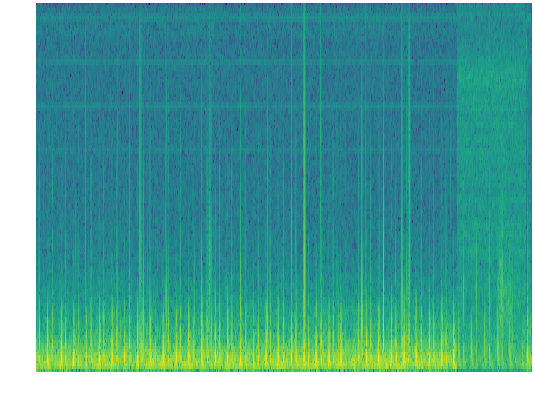

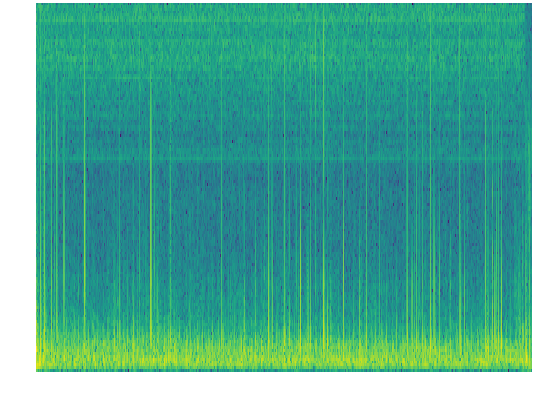

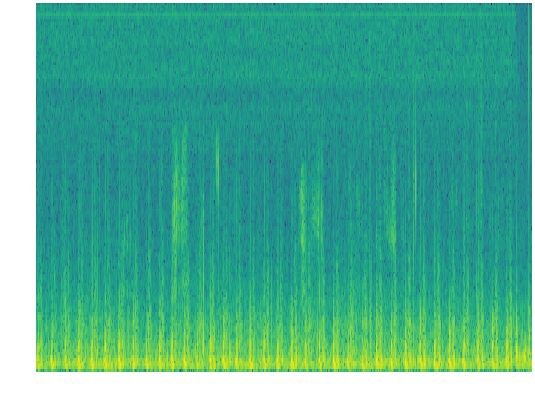

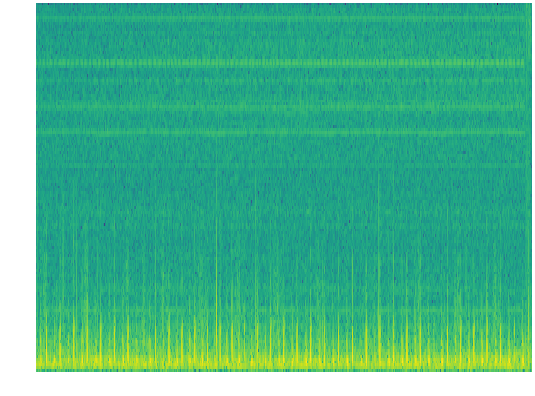

In [5]:
from IPython.display import Image
from IPython.display import display

listOfImageNames = ['data/train/normal/a0408.png',
                    'data/validation/normal/a0009.png',
                   'data/train/abnormal/a0117.png',
                   'data/validation/abnormal/a0001.png']


for imageName in listOfImageNames:
    display(Image(filename=imageName))

Counting number of images in training and validation set

In [28]:
import os

nor_train_dir = 'data/train/normal/'
nor_valid_dir = 'data/validation/normal/'
abnor_train_dir = 'data/train/abnormal/'
abnor_valid_dir = 'data/validation/abnormal/'

nor_train = len(next(os.walk(nor_train_dir))[2])
nor_valid = len(next(os.walk(nor_valid_dir))[2])
abnor_train = len(next(os.walk(abnor_train_dir))[2])
abnor_valid = len(next(os.walk(abnor_valid_dir))[2])

## We subtract 1 since every directory has a hidden file .DS_Store
print ('Number of samples in training set (normal): {}'.format((nor_train)-1))
print ('Number of samples in validation set (normal): {}'.format((nor_valid)-1))
print ('Number of samples in training set (abnormal): {}'.format((abnor_train)-1))
print ('Number of samples in validation set (abnormal): {}'.format((abnor_valid)-1))

Number of samples in training set (normal): 600
Number of samples in validation set (normal): 143
Number of samples in training set (abnormal): 400
Number of samples in validation set (abnormal): 82


Visualising the samples using matplotlib

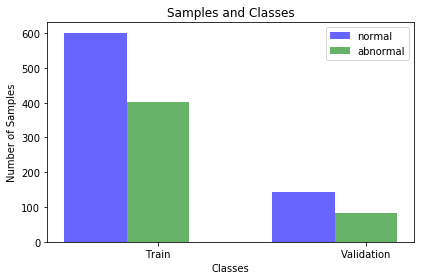

In [25]:
import numpy as np
import matplotlib.pyplot as plt
 
n_groups = 2

train_samples = (nor_train, nor_valid)
validation_samples = (abnor_train, abnor_valid)
 
fig, ax = plt.subplots()
index = np.arange(n_groups)
bar_width = 0.3
opacity = 0.6
 
rects1 = plt.bar(index, train_samples, bar_width,
                 alpha=opacity,
                 color='b',
                 label='normal')
 
rects2 = plt.bar(index + bar_width, validation_samples, bar_width,
                 alpha=opacity,
                 color='g',
                 label='abnormal')
 
plt.xlabel('Classes')
plt.ylabel('Number of Samples')
plt.title('Samples and Classes')
plt.xticks(index + bar_width, ('Train', 'Validation'))
plt.legend()
 
plt.tight_layout()
plt.show()

### Data Augmentation

One way to get around a lack of data as in our case (since we are only working with a subset of original dataset) is to augment the data. In terms of images, this means increasing the number of images in the dataset. There are many ways to augment data. For images this could be done by rotating the original image, changing lighting conditions, cropping it differently, so for one image we can generate different sub-samples. This way you can reduce overfitting and allow better generalization capability for our network.



For our model we would apply four data augmentation techniques as described below :
- Normalize pixel values between 0 and 1. This can be done by setting the 'rescale' attribute to 1/.255
- Appling [shear transformations](https://en.wikipedia.org/wiki/Shear_mapping). Can be done with the 'shear_range' attribute
- Zooming inside images uding 'zoom_range' attribute
- Flipping half of the images horizontally. This is done by setting the 'horizontal_flip' attribute to 'True'


To generate batches of images, Keras provides us with a handy 'ImageDataGenerator' class which takes in the above mentioned attributes and provides us with real-time data augmentation. The data will be looped over (in batches) indefinitely.

In [3]:
train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range = 0.2,
        zoom_range = 0.2,
        horizontal_flip = True
        )

test_datagen = ImageDataGenerator(rescale=1./255)

The 'ImageDataGenerator' class has the method 'flow_from_directory'.It takes the path to a directory, and generates batches of augmented data and yields batches in an infinite loop. It further provides us with the number of images in each set.

In [4]:
# automagically retrieve images and their classes for train and validation sets
train_generator = train_datagen.flow_from_directory(
        train_data_dir,
        target_size=(img_width, img_height),
        batch_size=32,
        class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
        validation_data_dir,
        target_size=(img_width, img_height),
        batch_size=32,
        class_mode='binary')

Found 1000 images belonging to 2 classes.
Found 225 images belonging to 2 classes.


Now that we have batches of images available to feed into the network we can now implement and train our model over these images. But before training our network we must define metrics for us to evaluate it.

### Evaluation

Evaluation Metrics help us to observe how well the model generalises on unseen data i.e to judge the performance of your model. For this project we will use the following metrics: 
- Accuracy 
- Precision 
- Recall
- f-Beta score

Since Keras only provides us with accuracy, we need to write our own custom metrics that can be passed at the compilation step.

In [5]:
import keras.backend as K

def precision(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision


def recall(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall


def fbeta_score(y_true, y_pred, beta=1):
    if beta < 0:
        raise ValueError('The lowest choosable beta is zero (only precision).')

    # If there are no true positives, fix the F score at 0 like sklearn.
    if K.sum(K.round(K.clip(y_true, 0, 1))) == 0:
        return 0

    p = precision(y_true, y_pred)
    r = recall(y_true, y_pred)
    bb = beta ** 2
    fbeta_score = (1 + bb) * (p * r) / (bb * p + r + K.epsilon())
    return fbeta_score

### Visualisation

It is always better if we are able to see visually how well our model is performing. Hence below we define simple visualisation methods.

In [6]:
import matplotlib.pyplot as plt
def results(history):
    # Accuracy
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['acc']); plt.plot(history.history['val_acc']);
    plt.title('model accuracy'); plt.ylabel('accuracy');
    plt.xlabel('epoch'); plt.legend(['train', 'valid'], loc='upper left');

    # Loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss']); plt.plot(history.history['val_loss']);
    plt.title('model loss'); plt.ylabel('loss');
    plt.xlabel('epoch'); plt.legend(['train', 'valid'], loc='upper left');
    plt.show()

### Convolutional Neural Networks

CNNs, like neural networks, are made up of neurons with learnable weights and biases. Each neuron receives several inputs, takes a weighted sum over them, pass it through an activation function and gives  an output. Convolutional Neural Networks take advantage of the fact that the input consists of images (i.e pixels closer together are more meaningful) and this allows us to encode certain properties into the architecture. This means that the forward function is more efficient to implement and hence vastly reduces the amount of parameters in the network. In particular, unlike a regular Neural Network, the layers of a ConvNet have neurons arranged in 3 dimensions: width, height, depth.

There are 3 types of layers present in Convolutional Neural Networks :
- Convolutional Layers: Convolution is a mathematical operation which is used to filter signals and find patterns in signals etc. In a convolutional layer, all neurons apply convolution operation to the inputs. The convolution layer comprises of a set of independent filters. Each filter is independently convolved with the image and we end up with n feature maps.
- Pooling Layers: This is mostly applied immediately after the convolutional layer to reduce the spatial size(only width and height, not depth). This reduces the number of parameters, hence computation is reduced. Also, less number of parameters avoid overfitting. The most common form of pooling is Max pooling where we take a filter of size n*n and apply the maximum operation over the n*n sized part of the image.
- Fully Connected Layer: This layer just computes the matrix multiplication of inputs recieved from neurons in the previous layer followed by bias offset.

### Model 1

We will first try a very small CNN with few layers and few filters per layer.

In [108]:
model = Sequential()
model.add(Convolution2D(32, 3, 3, input_shape=(img_width, img_height,3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Convolution2D(64, 3, 3))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Convolution2D(128, 3, 3))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Convolution2D(128, 3, 3))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(256))
model.add(Activation('relu'))
model.add(Dense(1))
model.add(Activation('sigmoid'))

In [109]:
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy',precision,recall,fbeta_score])

In [110]:
nb_epoch = 3
nb_train_samples = 1000
nb_validation_samples = 225

In [111]:
history = model.fit_generator(
        train_generator,
        samples_per_epoch=nb_train_samples,
        nb_epoch=nb_epoch,
        validation_data=validation_generator,
        nb_val_samples=nb_validation_samples)

Epoch 1/3
1000/1000 [==============================] - 24s - loss: 0.6578 - acc: 0.5950 - precision: 0.6215 - recall: 0.8242 - fbeta_score: 0.6736 - val_loss: 0.6241 - val_acc: 0.6756 - val_precision: 0.6756 - val_recall: 1.0000 - val_fbeta_score: 0.8039

In [112]:
model.evaluate_generator(validation_generator, nb_validation_samples) ## [Loss,
                                                                      ##  Accuracy,
                                                                      ##  Precision,
                                                                      ##  Recall
                                                                      ##  F-BetaScore]

[0.62865560372670493,
 0.66222222222222227,
 0.65594199233584938,
 0.97572449525197347,
 0.78163521581225925]

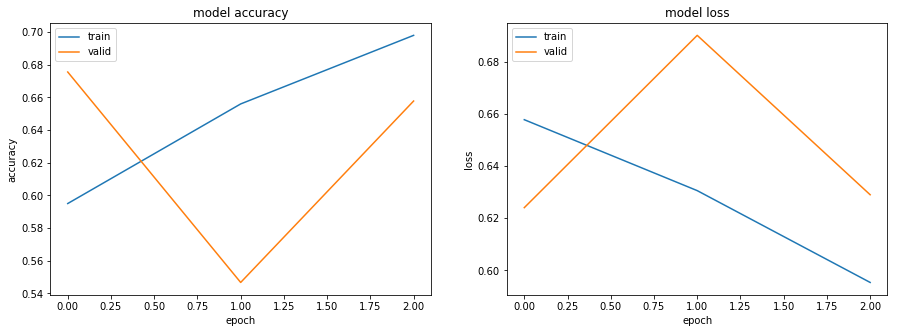

In [113]:
results(history)

We will now implement a more deeper CNN with more number of layers and number of neurons in each layer. We also use techniques to reduce overfitting if any with dropout and batch normalisation. All these techniques have been discussed in detail in the report for this capstone.

### Model 2

We now implement a deeper CNN. 

In [17]:
model = Sequential()
model.add(ZeroPadding2D((1,1),input_shape=(img_width,img_height,3)))
model.add(Convolution2D(64, 3, 3))
model.add(BatchNormalization())          
model.add(Activation('relu'))
model.add(MaxPooling2D((2,2), strides=(2,2)))

model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(128, 3, 3))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D((2,2), strides=(2,2)))

model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(256, 3, 3))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D((2,2), strides=(2,2)))

model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(512, 3, 3))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D((2,2), strides=(2,2)))

model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(512, 3, 3))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D((2,2), strides=(2,2)))

model.add(Flatten())
model.add(Dense(1024))
model.add(BatchNormalization())
model.add(Activation('relu'))          
model.add(Dropout(0.5))
model.add(Dense(1))
model.add(BatchNormalization())
model.add(Activation('sigmoid'))

In [19]:
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy',precision,recall,fbeta_score])

In [18]:
nb_epoch = 3
nb_train_samples = 1000
nb_validation_samples = 225

In [20]:
history = model.fit_generator(
        train_generator,
        samples_per_epoch=nb_train_samples,
        nb_epoch=nb_epoch,
        validation_data=validation_generator,
        nb_val_samples=nb_validation_samples)

Epoch 1/3
1000/1000 [==============================] - 47s - loss: 0.6224 - acc: 0.6680 - precision: 0.7582 - recall: 0.6605 - fbeta_score: 0.7026 - val_loss: 0.6648 - val_acc: 0.6311 - val_precision: 0.6317 - val_recall: 0.9921 - val_fbeta_score: 0.7704

In [21]:
model.evaluate_generator(validation_generator, nb_validation_samples) ## [Loss,
                                                                      ##  Accuracy,
                                                                      ##  Precision,
                                                                      ##  Recall
                                                                      ##  F-BetaScore]

[0.67200217379464044,
 0.60444445133209224,
 0.60444444259007768,
 1.0,
 0.75332638661066686]

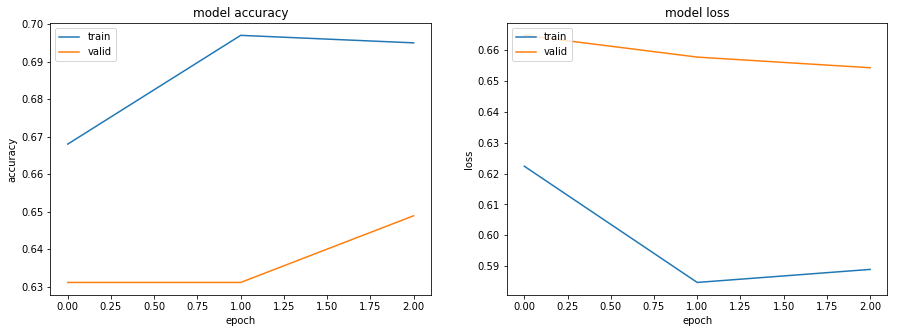

In [22]:
results(history)

### Model 3

Transfer Learning

### Transfer Learning and using pre-trained models

Transfer Learning allows us to use pre-trained models trained on datasets with millions of images such as COCO, Imagenet etc. This means instead of building a model from scratch to solve a similar dataset, we can use the model trained on some other dataset as a starting point. Hence by using pre-trained models which have been previously trained on large datasets, we can directly use the weights and architecture obtained and apply the learning on our problem statement and allow us to reach a better accuracy than any method. You can read more about it [here](https://medium.com/@galen.ballew/transferlearning-b65772083b47)

For our problem, we are going to the VGG16 model which is available in Keras already. It is Deep convolutional network for object recognition developed and trained by Oxford's renowned Visual Geometry Group (VGG), which achieved very [good performance](http://www.robots.ox.ac.uk/~vgg/research/very_deep/) on the ImageNet dataset.

#### VGG16 Model

Here we implement the VGG16 network. We only use the network upto the fully connected network and remove all subseuent layers. The weights file for VGG16 is available [here](https://drive.google.com/file/d/0Bz7KyqmuGsilT0J5dmRCM0ROVHc/view)

!['VGG16 Architecture'](vgg16.png)

In [51]:
model_vgg = Sequential()
model_vgg.add(ZeroPadding2D((1, 1), input_shape=(img_width, img_height, 3)))

model_vgg.add(Convolution2D(64, 3, 3, activation='relu', name='conv1_1'))
model_vgg.add(ZeroPadding2D((1, 1)))
model_vgg.add(Convolution2D(64, 3, 3, activation='relu', name='conv1_2'))
model_vgg.add(MaxPooling2D((2, 2), strides=(2, 2)))

model_vgg.add(ZeroPadding2D((1, 1)))
model_vgg.add(Convolution2D(128, 3, 3, activation='relu', name='conv2_1'))
model_vgg.add(ZeroPadding2D((1, 1)))
model_vgg.add(Convolution2D(128, 3, 3, activation='relu', name='conv2_2'))
model_vgg.add(MaxPooling2D((2, 2), strides=(2, 2)))

model_vgg.add(ZeroPadding2D((1, 1)))
model_vgg.add(Convolution2D(256, 3, 3, activation='relu', name='conv3_1'))
model_vgg.add(ZeroPadding2D((1, 1)))
model_vgg.add(Convolution2D(256, 3, 3, activation='relu', name='conv3_2'))
model_vgg.add(ZeroPadding2D((1, 1)))
model_vgg.add(Convolution2D(256, 3, 3, activation='relu', name='conv3_3'))
model_vgg.add(MaxPooling2D((2, 2), strides=(2, 2)))

model_vgg.add(ZeroPadding2D((1, 1)))
model_vgg.add(Convolution2D(512, 3, 3, activation='relu', name='conv4_1'))
model_vgg.add(ZeroPadding2D((1, 1)))
model_vgg.add(Convolution2D(512, 3, 3, activation='relu', name='conv4_2'))
model_vgg.add(ZeroPadding2D((1, 1)))
model_vgg.add(Convolution2D(512, 3, 3, activation='relu', name='conv4_3'))
model_vgg.add(MaxPooling2D((2, 2), strides=(2, 2)))

model_vgg.add(ZeroPadding2D((1, 1)))
model_vgg.add(Convolution2D(512, 3, 3, activation='relu', name='conv5_1'))
model_vgg.add(ZeroPadding2D((1, 1)))
model_vgg.add(Convolution2D(512, 3, 3, activation='relu', name='conv5_2'))
model_vgg.add(ZeroPadding2D((1, 1)))
model_vgg.add(Convolution2D(512, 3, 3, activation='relu', name='conv5_3'))
model_vgg.add(MaxPooling2D((2, 2), strides=(2, 2)))

We must now load the weights (vgg16_weights.h5) since the structure of our model is not exactly the same as the one used when training weights. If it was, we could have just used the in-built mehtod as model.load_weights( ).

In [52]:
from keras import backend as K
K.set_image_dim_ordering('tf')

import h5py
f = h5py.File('vgg16_weights.h5')

for k in range(f.attrs['nb_layers']):
    if k >= len(model_vgg.layers):
        break
    g = f['layer_{}'.format(k)]
    weights = [g['param_{}'.format(p)] for p in range(g.attrs['nb_params'])]
    
    if (len(weights)>0):
        #weights[0].shape = weight_shape
        weights[0] = np.transpose(weights[0], (2, 3, 1, 0))    
    model_vgg.layers[k].set_weights(weights)
f.close()

Processing the batches for VGG16 model

In [53]:
train_generator_bottleneck = train_datagen.flow_from_directory(
        train_data_dir,
        target_size=(img_width, img_height),
        batch_size=32,
        class_mode=None,
        shuffle=False)

validation_generator_bottleneck = test_datagen.flow_from_directory(
        validation_data_dir,
        target_size=(img_width, img_height),
        batch_size=32,
        class_mode=None,
        shuffle=False)

Found 1000 images belonging to 2 classes.
Found 225 images belonging to 2 classes.


Saving the ourput of our VGG16 model since it takes a while to train and it not efficient to run it everytime

In [54]:
bottleneck_features_train = model_vgg.predict_generator(train_generator_bottleneck, nb_train_samples)
np.save(open('models/bottleneck_features_train.npy', 'wb'), bottleneck_features_train)

bottleneck_features_validation = model_vgg.predict_generator(validation_generator_bottleneck, nb_validation_samples)
np.save(open('models/bottleneck_features_validation.npy', 'wb'), bottleneck_features_validation)

In [55]:
print (bottleneck_features_train.shape)
print (bottleneck_features_validation.shape)

(1000, 4, 4, 512)
(225, 4, 4, 512)


Loading VGG16's output.

In [56]:
train_data = np.load(open('models/bottleneck_features_train.npy', 'rb'))
train_labels = np.array([0] * (nb_train_samples // 2) + [1] * (nb_train_samples // 2))

validation_data = np.load(open('models/bottleneck_features_validation.npy', 'rb'))
validation_labels = np.array([0] * (nb_validation_samples // 2) + [1] * (nb_validation_samples // 2))

VGG16 was trained for more than 100 classes. But here we are only trying to classify into normal or abnormal. So we now add our own custom fully connected layer.

In [74]:
model_top = Sequential()
model_top.add(Flatten(input_shape=train_data.shape[1:]))
model_top.add(Dense(1024, activation='relu'))
model_top.add(Dropout(0.5))
model_top.add(Dense(1, activation='sigmoid'))

In [75]:
model_top.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy',precision,recall,fbeta_score])

In [76]:
nb_epoch = 50

In [77]:
history = model_top.fit(train_data,
                        train_labels,
                        nb_epoch=nb_epoch,
                        batch_size=32,
                        validation_data=(validation_data, validation_labels))

Train on 1000 samples, validate on 225 samples
Epoch 1/50
1000/1000 [==============================] - 0s - loss: 1.2139 - acc: 0.5410 - precision: 0.4711 - recall: 0.5493 - fbeta_score: 0.4761 - val_loss: 0.7138 - val_acc: 0.5511 - val_precision: 44444.9659 - val_recall: 0.1200 - val_fbeta_score: 0.1950

Saving the weights 

In [78]:
model_top.save_weights('models/1000-samples.h5')

Loading the weights

In [79]:
model_top.load_weights('models/1000-samples.h5')

Evaluating our model on test set and visualising the results.

In [80]:
model_top.evaluate(validation_data, validation_labels) ## [Loss,
                                                       ##  Accuracy,
                                                       ##  Precision,
                                                       ##  Recall
                                                       ##  F-BetaScore]

 32/225 [===>..........................] - ETA: 0s

[2.010920474794176,
 0.54222222222222227,
 0.52148148430718311,
 0.088888888888888892,
 0.15103901121351454]

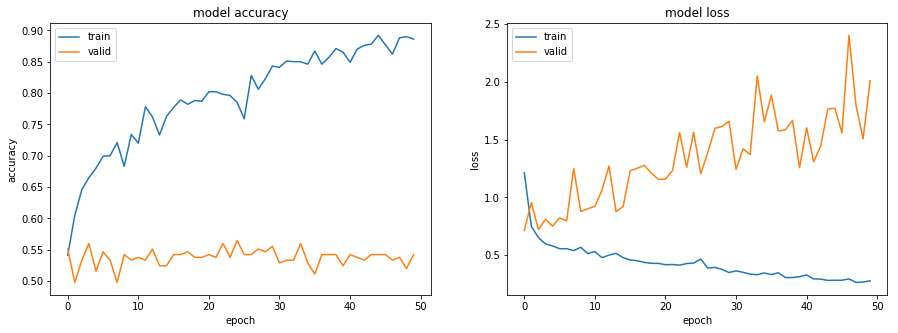

In [81]:
results(history)

### Model 4

Based on VGG16 Architecture

Finally, just for experimental purposes, I train the VGG16 full architecture with my dataset to see if there are any improvement in validation accuracy and validation loss

In [7]:
def VGG_16():
    model = Sequential()
    model.add(ZeroPadding2D((1,1),input_shape=(img_width,img_height,3)))
    model.add(Convolution2D(64, 3, 3, activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(64, 3, 3, activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))

    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(128, 3, 3, activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(128, 3, 3, activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))

    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(256, 3, 3, activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(256, 3, 3, activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(256, 3, 3, activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))

    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, 3, 3, activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, 3, 3, activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, 3, 3, activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))

    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, 3, 3, activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, 3, 3, activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, 3, 3, activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))

    model.add(Flatten())
    model.add(Dense(4096, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(4096, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))

    return model

In [8]:
model= VGG_16()
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy',precision,recall,fbeta_score])

In [9]:
nb_epoch = 3
nb_train_samples = 1000
nb_validation_samples = 225

In [10]:
history = model.fit_generator(
        train_generator,
        samples_per_epoch=nb_train_samples,
        nb_epoch=nb_epoch,
        validation_data=validation_generator,
        nb_val_samples=nb_validation_samples)

Epoch 1/3
1000/1000 [==============================] - 93s - loss: 0.7995 - acc: 0.5730 - precision: 0.4929 - recall: 0.7978 - fbeta_score: 0.6052 - val_loss: 0.6752 - val_acc: 0.6356 - val_precision: 0.6356 - val_recall: 0.9956 - val_fbeta_score: 0.7726

In [11]:
model.evaluate_generator(validation_generator, nb_validation_samples) ## [Loss,
                                                                      ##  Accuracy,
                                                                      ##  Precision,
                                                                      ##  Recall
                                                                      ##  F-BetaScore]

[0.65342555258009172,
 0.65333333333333332,
 0.65333333333333332,
 0.99555555555555553,
 0.7859131791856554]

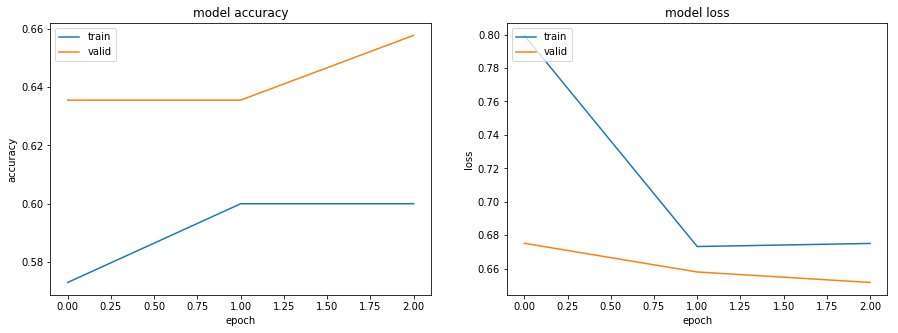

In [12]:
results(history)